In [2]:
import numpy as np
import numpy.random as nrand
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
import itertools
from sklearn.linear_model import LinearRegression
import uncertainties as unc
import uncertainties.unumpy as unp
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')

In [3]:
N_list = [5,10,15]
model_list = ['NK','RMF','Polynomial']
metric_list = ['N_max','epi','r_s','blocked_ratio','E','1-gamma','1/adptwalk_steps','1-adptwalk_probs']
method_list = ['HT3','Logistic','Algebraic1','Algebraic2','Algebraic3','Cubic','Quadratic','Linear']

In [4]:
with open('extrapolation_model_selection_result.pkl','rb') as f:
    all_df = pickle.load(f)

In [5]:
ruggedness_measure_dict = {'N_max':'$\mathit{N}_{max}$','epi':'$\mathit{F}_{rse}$','r_s':'$\mathit{r/s}$','blocked_ratio':'$\mathit{F}_{bp}$',
                           'E':'$\mathit{E}$','1-gamma':'$1-\mathit{\gamma}$','1/adptwalk_steps':'$1/\mathit{N}_{adapt}$','1-adptwalk_probs':'$1-\mathit{P}_{adapt}$'}


In [6]:
# Plotting parameters

para_dict = {
    5:{
        'N_max':{'xlim':[-10,10],'ylim':[0,200]},
        'epi':{'xlim':[-0.25,0.25],'ylim':[0,200]},
        'r_s':{'xlim':[-1.5,1.5],'ylim':[0,200]},
        'blocked_ratio':{'xlim':[-0.25,0.25],'ylim':[0,200]},
        'E':{'xlim':[-1,1],'ylim':[0,200]},
        '1-gamma':{'xlim':[-0.25,0.25],'ylim':[0,200]},
        '1/adptwalk_steps':{'xlim':[-1.5,1.5],'ylim':[0,200]},
        '1-adptwalk_probs':{'xlim':[-0.25,0.25],'ylim':[0,200]},
    },
    10:{
        'N_max':{'xlim':[-50,100],'ylim':[-80,80]},
        'epi':{'xlim':[-0.05,0.15],'ylim':[-0.075,0.125]},
        'r_s':{'xlim':[-1,2.5],'ylim':[-1,1]},
        'blocked_ratio':{'xlim':[-0.1,0.15],'ylim':[-0.3,0.3]},
        'E':{'xlim':[-0.1,0.5],'ylim':[-0.14,0.2]},
        '1-gamma':{'xlim':[-0.1,0.5],'ylim':[-0.25,0.4]},
        '1/adptwalk_steps':{'xlim':[-0.5,0.5],'ylim':[-0.4,0.4]},
        '1-adptwalk_probs':{'xlim':[-1,1],'ylim':[-2.5,2.5]},
    },
    15:{
        'N_max':{'xlim':[-250,1200],'ylim':[0,200]},
        'epi':{'xlim':[-0.03,0.16],'ylim':[0,200]},
        'r_s':{'xlim':[-1,3],'ylim':[0,200]},
        'blocked_ratio':{'xlim':[-0.1,0.15],'ylim':[0,200]},
        'E':{'xlim':[-1,1],'ylim':[0,200]},
        '1-gamma':{'xlim':[-0.03,0.16],'ylim':[0,200]},
        '1/adptwalk_steps':{'xlim':[-1,3],'ylim':[0,200]},
        '1-adptwalk_probs':{'xlim':[-0.1,0.15],'ylim':[0,200]},
    }
}

title_dict = {
    'model': '{} model',
    'replication': '{} replicates',
    'ruggedness': 'Ruggedness level {}',
    'measurement_std': 'Estimation error sd {:.3}'
}

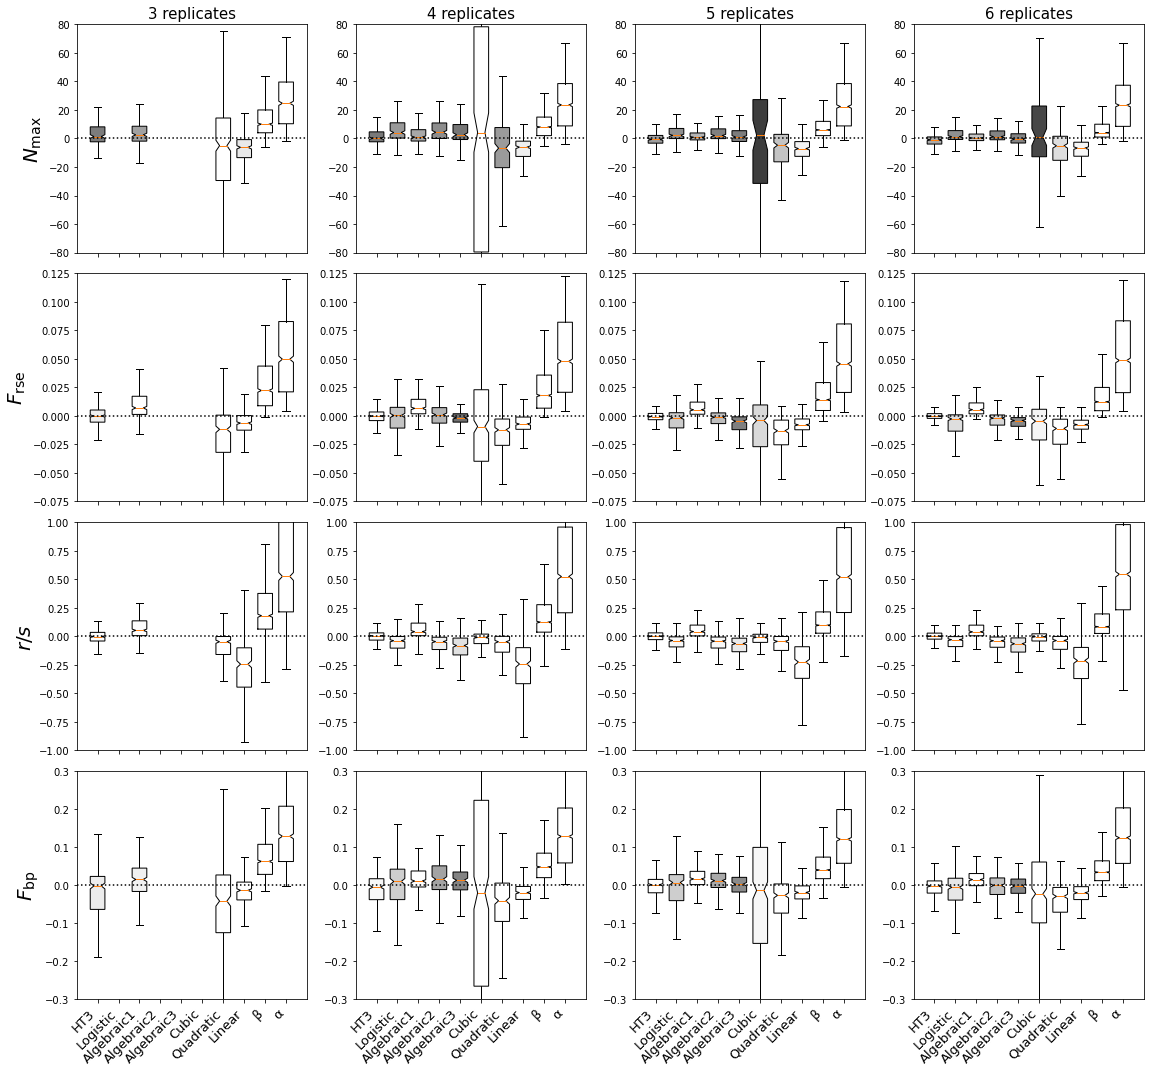

In [7]:
# N_site: number of variable site of landscape; parameter: parameter for data stratification 
# N_site: 5, 10, 15; parameter: 'model', 'replication', 'ruggedness', 'measurement_std'
N_site=10
parameter='replication'

cv_cutoff = 0.5
show_all_A_B = False # If use all available alpha and beta value even though some data might 
                     # fail the extrapolation. Default is False.

fig,axes = plt.subplots(4,4,figsize=[16,15])
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

for j,metric in enumerate(['N_max','epi','r_s','blocked_ratio']):
    for i,rep in enumerate([3,4,5,6]):
        ax = axes[j,i]
        xlim = para_dict[N_site][metric]['xlim']
        ylim = para_dict[N_site][metric]['ylim']
        idx_all = (all_df['metric'] == metric) & (all_df['N_site'] == N_site) & (all_df[parameter] == rep)
        idx = idx_all & (all_df['accept']==True)
        
        for k,method in enumerate(method_list):
            idx_method = idx & (all_df['method']==method)
            #sns.boxplot(data=all_df['C'][idx_method], ax=ax)
            ac = idx_method.sum()/(idx_all & (all_df['method']==method)).sum()
            ax.boxplot(all_df['C'][idx_method],positions=[k],showfliers=False,widths=0.7,\
                      notch=True, patch_artist=True, boxprops=dict(facecolor=plt.cm.gray(ac)))
        
        ax.boxplot(all_df['B'][idx],positions=[k+1],showfliers=False,widths=0.7,notch=True)
        ax.boxplot(all_df['A'][idx],positions=[k+2],showfliers=False,widths=0.7,notch=True)
        
        ax.plot([-1,10],[0,0],'k:',zorder=10)
        ax.set_xlim([-1,10])
        ax.set_ylim(ylim)
        #plt.xticks(fontsize=15)
        if j == 0:
            ax.set_title(title_dict[parameter].format(rep),fontsize=15)
        if i == 0:
            ax.set_ylabel(f'{ruggedness_measure_dict[metric]}',fontsize = 20)
        if j == 3:
            #ax.set_xticklabels(['','','','δ','','','','','β','α'],fontsize=20)
            ax.set_xticklabels(method_list+['β','α'],fontsize=13)
            
            
        else:
            ax.xaxis.set_ticklabels([])
        
fig.autofmt_xdate(rotation=45)
plt.tight_layout()

plt.savefig('result.pdf')

In [180]:
# np.random.seed(19680801)
# plt.subplots(figsize=[10,6])
# plt.imshow(np.random.random((0, 0)), cmap=plt.cm.gray,)

# #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.1, 0.5, 0.75, 0.05])
# plt.colorbar(cax=cax,orientation='horizontal')
# #plt.show()
# plt.tight_layout()
# plt.savefig('colorbar.svg')

In [8]:
#idx_r,idx_c = np.where((np.abs(all_df[['A','B','C']]) < 1e-30)  &  (np.abs(all_df[['A','B','C']]) != 0))
all_df[(np.abs(all_df['C']) < 1e-30)  &  (np.abs(all_df['C']) != 0)]['C'] = 0

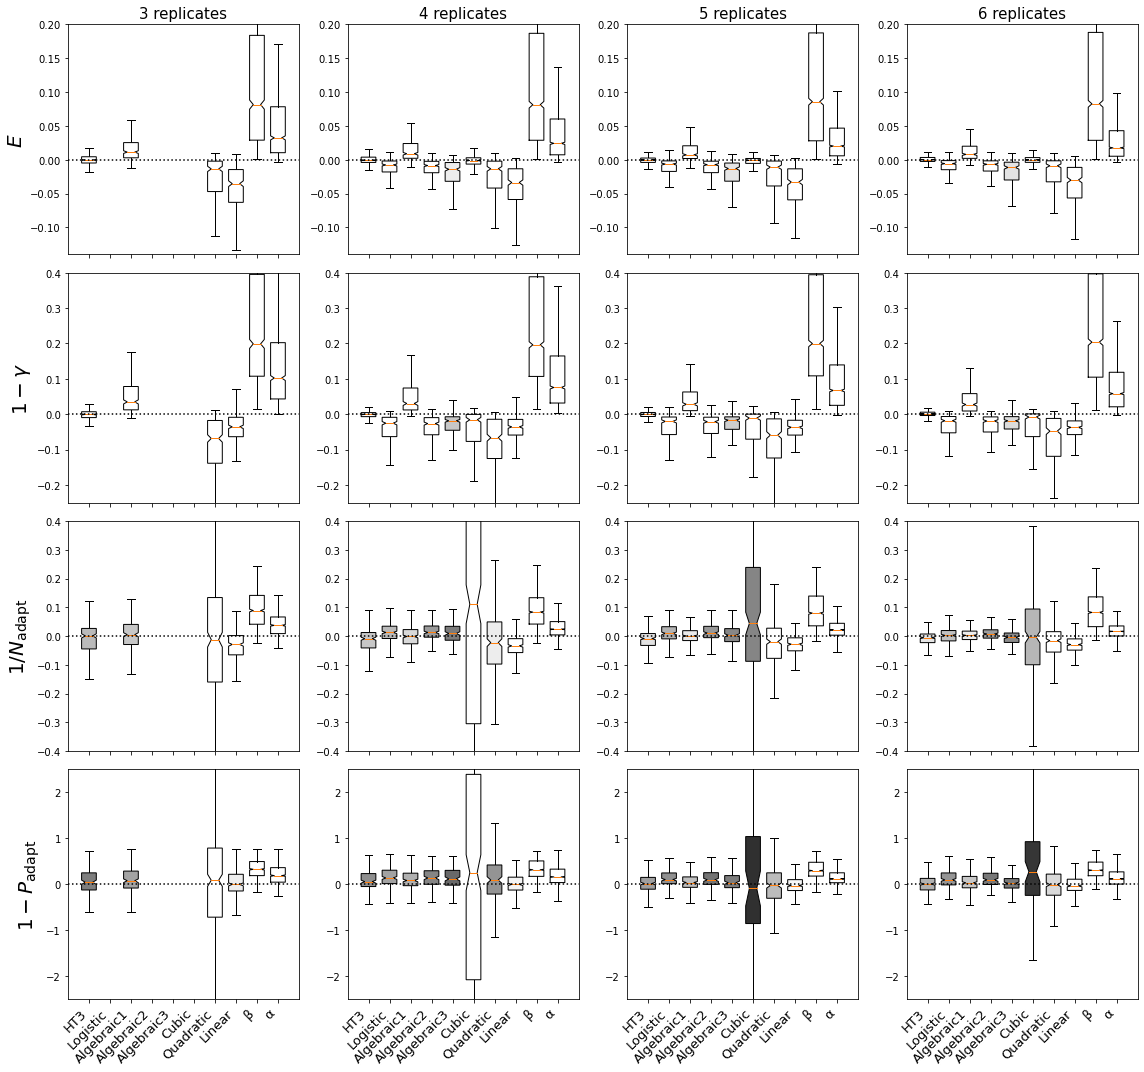

In [9]:
# N_site: number of variable site of landscape; parameter: parameter for data stratification 
# N_site: 5, 10, 15; parameter: 'model', 'replication', 'ruggedness', 'measurement_std'
N_site=10
parameter='replication'

cv_cutoff = 0.5
show_all_A_B = False # If use all available alpha and beta value even though some data might 
                     # fail the extrapolation. Default is False.
fig,axes = plt.subplots(4,4,figsize=[16,15])
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

for j,metric in enumerate(['E','1-gamma','1/adptwalk_steps','1-adptwalk_probs']):
    for i,rep in enumerate([3,4,5,6]):
        ax = axes[j,i]
        xlim = para_dict[N_site][metric]['xlim']
        ylim = para_dict[N_site][metric]['ylim']
        idx_all = (all_df['metric'] == metric) & (all_df['N_site'] == N_site) & (all_df[parameter] == rep)
        idx = idx_all & (all_df['accept']==True)
        
        for k,method in enumerate(method_list):
            idx_method = idx & (all_df['method']==method)
            #sns.boxplot(data=all_df['C'][idx_method], ax=ax)
            ac = idx_method.sum()/(idx_all & (all_df['method']==method)).sum()
            if idx_method.sum() == 0:
                ac=0
            ax.boxplot(all_df['C'][idx_method],positions=[k],showfliers=False,widths=0.7,\
                      notch=True, patch_artist=True, boxprops=dict(facecolor=plt.cm.gray(ac)))
            
        ax.boxplot(all_df['A'][idx],positions=[k+1],showfliers=False,widths=0.7,notch=True)
        ax.boxplot(all_df['B'][idx],positions=[k+2],showfliers=False,widths=0.7,notch=True)
        ax.plot([-1,10],[0,0],'k:',zorder=10)
        ax.set_xlim([-1,10])
        ax.set_ylim(ylim)
        if j == 0:
            ax.set_title(title_dict[parameter].format(rep),fontsize=15)
        if i == 0:
            ax.set_ylabel(f'{ruggedness_measure_dict[metric]}',fontsize = 20)
        if j == 3:
            #ax.set_xticklabels(['','','','δ','','','','','β','α'],fontsize=20)
            ax.set_xticklabels(method_list+['β','α'],fontsize=13)
        else:
            ax.xaxis.set_ticklabels([])
            

fig.autofmt_xdate(rotation=45)
plt.tight_layout()

plt.savefig('result2.pdf')

In [10]:
# Plotting parameters

para_dict = {
    5:{
        'N_max':{'xlim':[-5,5],'ylim':[0,200]},
        'epi':{'xlim':[-0.2,0.2],'ylim':[0,200]},
        'r_s':{'xlim':[-1,1],'ylim':[0,200]},
        'blocked_ratio':{'xlim':[-0.4,0.4],'ylim':[0,200]},
        'E':{'xlim':[-1,1],'ylim':[0,200]},
        '1-gamma':{'xlim':[-0.25,0.25],'ylim':[0,200]},
        '1/adptwalk_steps':{'xlim':[-1.5,1.5],'ylim':[0,200]},
        '1-adptwalk_probs':{'xlim':[-0.25,0.25],'ylim':[0,200]},
    },
    10:{
        'N_max':{'xlim':[-50,100],'ylim':[0,200]},
        'epi':{'xlim':[-0.05,0.15],'ylim':[0,200]},
        'r_s':{'xlim':[-1,2.5],'ylim':[0,200]},
        'blocked_ratio':{'xlim':[-0.4,0.6],'ylim':[0,200]},
        'E':{'xlim':[-0.1,0.5],'ylim':[0,250]},
        '1-gamma':{'xlim':[-0.1,0.5],'ylim':[0,250]},
        '1/adptwalk_steps':{'xlim':[-0.5,0.5],'ylim':[0,200]},
        '1-adptwalk_probs':{'xlim':[-1,1],'ylim':[0,200]},
    },
    15:{
        'N_max':{'xlim':[-300,1500],'ylim':[0,200]},
        'epi':{'xlim':[-0.03,0.16],'ylim':[0,200]},
        'r_s':{'xlim':[-1,3],'ylim':[0,200]},
        'blocked_ratio':{'xlim':[-0.5,0.8],'ylim':[0,200]},
        'E':{'xlim':[-1,1],'ylim':[0,200]},
        '1-gamma':{'xlim':[-0.03,0.16],'ylim':[0,200]},
        '1/adptwalk_steps':{'xlim':[-1,3],'ylim':[0,200]},
        '1-adptwalk_probs':{'xlim':[-0.1,0.15],'ylim':[0,200]},
    }
}


title_dict = {
    'model': '{} model',
    'replication': '{} replicates',
    'ruggedness': 'Ruggedness level {}',
    'measurement_std': 'Estimation error sd {:.3}'
}

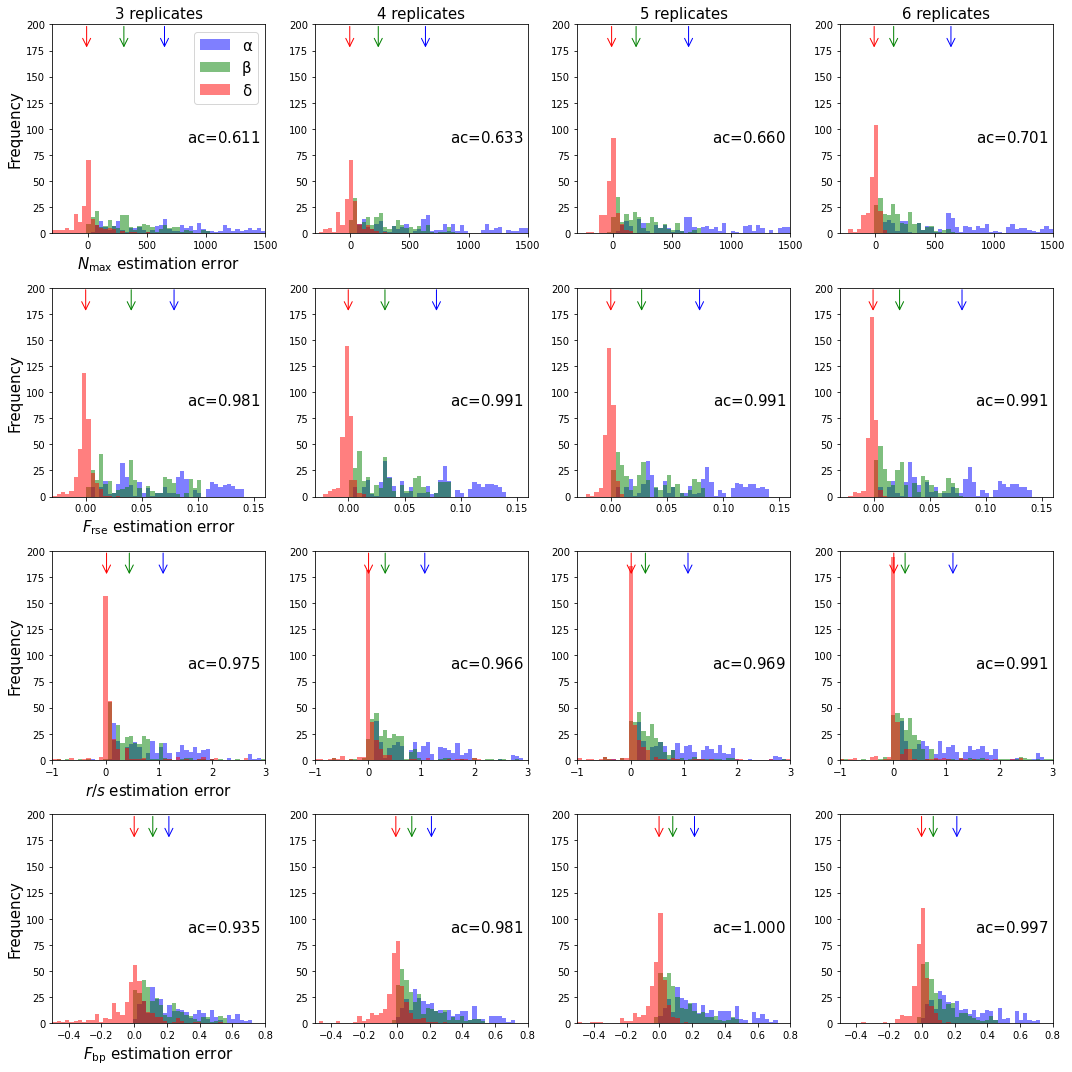

In [14]:
# N_site: number of variable site of landscape; parameter: parameter for data stratification 
# N_site: 5, 10, 15; parameter: 'model', 'replication', 'ruggedness', 'measurement_std'
N_site=15
parameter='replication'

cv_cutoff = 0.5
show_all_A_B = False # If use all available alpha and beta value even though some data might 
                     # fail the extrapolation. Default is False.

fig,axes = plt.subplots(4,4,figsize=[15,15])

#for j,metric in enumerate(['E','1-gamma','1/adptwalk_steps','1-adptwalk_probs']):
for j,metric in enumerate(['N_max','epi','r_s','blocked_ratio']):   
    for i,rep in enumerate([3,4,5,6]):
        ax = axes[j,i]
        xlim = para_dict[N_site][metric]['xlim']
        ylim = para_dict[N_site][metric]['ylim']
        idx_all = (all_df['metric'] == metric) & (all_df['N_site'] == N_site) & (all_df[parameter] == rep) \
                    & (all_df['method'] == 'HT3')
        idx = idx_all & (all_df['accept']==True)
        ac = idx.sum()/idx_all.sum()
        for index,color,label in zip(['A','B','C'],['b','g','r'],['α','β','δ']):
            if show_all_A_B and index != 'C':
                hist_df = all_df[index][idx_all]
            else:
                hist_df = all_df[index][idx]
            ax.hist(hist_df, bins = 50,range=(xlim[0],xlim[1]),alpha=0.5, color = color, label=label)

            ax.annotate(s=None,xy=(np.median(hist_df), ylim[1]*22/25), xytext=(np.median(hist_df),ylim[1]),
                         arrowprops={'arrowstyle': '->', 'color': color}, va='center',size=20)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.text(0.98, 0.5, f'$ac$={ac:.3f}', horizontalalignment='right',
                verticalalignment='top', transform=ax.transAxes, fontsize=15)
        if j == 0:
            ax.set_title(title_dict[parameter].format(rep),fontsize=15)
        if i == 0:
            ax.set_ylabel(f'Frequency',fontsize = 15)
            ax.set_xlabel(f'{ruggedness_measure_dict[metric]} estimation error', fontsize = 15)
        if (i == 0) & (j == 0):
            ax.legend(prop={'size': 15})

plt.tight_layout()
plt.show()

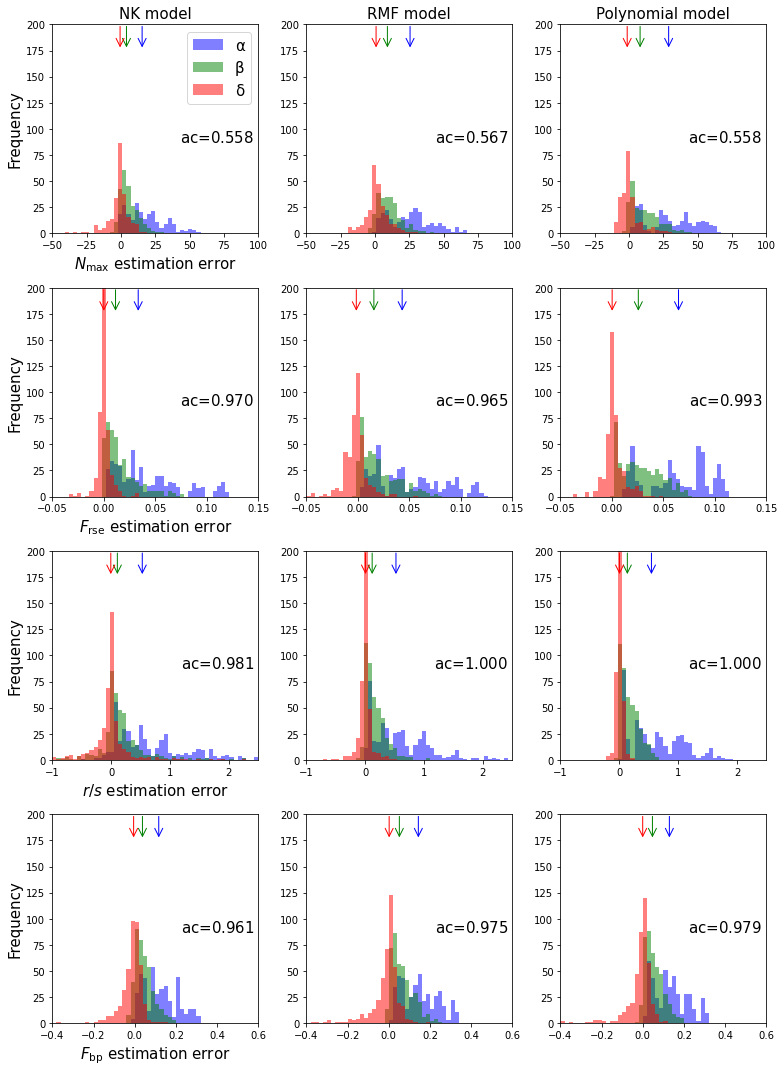

In [15]:
# N_site: number of variable site of landscape; parameter: parameter for data stratification 
# N_site: 5, 10, 15; parameter: 'model', 'replication', 'ruggedness', 'measurement_std'
N_site=10
parameter='model'

cv_cutoff = 0.5
show_all_A_B = False # If use all available alpha and beta value even though some data might 
                     # fail the extrapolation. Default is False.

fig,axes = plt.subplots(4,3,figsize=[11,15])

#for j,metric in enumerate(['E','1-gamma','1/adptwalk_steps','1-adptwalk_probs']):
for j,metric in enumerate(['N_max','epi','r_s','blocked_ratio']):   
    for i,rep in enumerate(model_list):
        ax = axes[j,i]
        xlim = para_dict[N_site][metric]['xlim']
        ylim = para_dict[N_site][metric]['ylim']
        idx_all = (all_df['metric'] == metric) & (all_df['N_site'] == N_site) & (all_df[parameter] == rep) \
                    & (all_df['method'] == 'HT3')
        idx = idx_all & (all_df['accept']==True)
        ac = idx.sum()/idx_all.sum()
        for index,color,label in zip(['A','B','C'],['b','g','r'],['α','β','δ']):
            if show_all_A_B and index != 'C':
                hist_df = all_df[index][idx_all]
            else:
                hist_df = all_df[index][idx]
            ax.hist(hist_df, bins = 50,range=(xlim[0],xlim[1]),alpha=0.5, color = color, label=label)

            ax.annotate(s=None,xy=(np.median(hist_df), ylim[1]*22/25), xytext=(np.median(hist_df),ylim[1]),
                         arrowprops={'arrowstyle': '->', 'color': color}, va='center',size=20)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.text(0.98, 0.5, f'$ac$={ac:.3f}', horizontalalignment='right',
                verticalalignment='top', transform=ax.transAxes, fontsize=15)
        if j == 0:
            ax.set_title(title_dict[parameter].format(rep),fontsize=15)
        if i == 0:
            ax.set_ylabel(f'Frequency',fontsize = 15)
            ax.set_xlabel(f'{ruggedness_measure_dict[metric]} estimation error', fontsize = 15)
        if (i == 0) & (j == 0):
            ax.legend(prop={'size': 15})

plt.tight_layout()
plt.show()

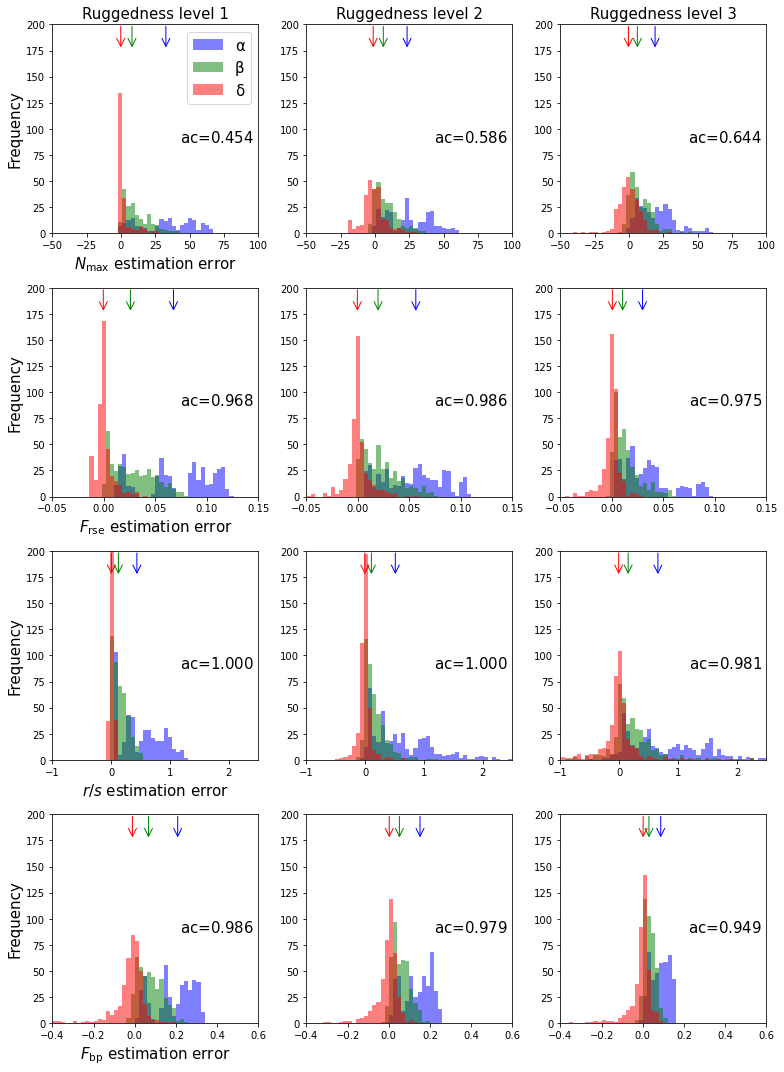

In [16]:
# N_site: number of variable site of landscape; parameter: parameter for data stratification 
# N_site: 5, 10, 15; parameter: 'model', 'replication', 'ruggedness', 'measurement_std'
N_site=10
parameter='ruggedness'

cv_cutoff = 0.5
show_all_A_B = False # If use all available alpha and beta value even though some data might 
                     # fail the extrapolation. Default is False.

fig,axes = plt.subplots(4,3,figsize=[11,15])

#for j,metric in enumerate(['E','1-gamma','1/adptwalk_steps','1-adptwalk_probs']):
for j,metric in enumerate(['N_max','epi','r_s','blocked_ratio']):   
    for i,rep in enumerate([1,2,3]):
        ax = axes[j,i]
        xlim = para_dict[N_site][metric]['xlim']
        ylim = para_dict[N_site][metric]['ylim']
        idx_all = (all_df['metric'] == metric) & (all_df['N_site'] == N_site) & (all_df[parameter] == rep) \
                    & (all_df['method'] == 'HT3')
        idx = idx_all & (all_df['accept']==True)
        ac = idx.sum()/idx_all.sum()
        for index,color,label in zip(['A','B','C'],['b','g','r'],['α','β','δ']):
            if show_all_A_B and index != 'C':
                hist_df = all_df[index][idx_all]
            else:
                hist_df = all_df[index][idx]
            ax.hist(hist_df, bins = 50,range=(xlim[0],xlim[1]),alpha=0.5, color = color, label=label)

            ax.annotate(s=None,xy=(np.median(hist_df), ylim[1]*22/25), xytext=(np.median(hist_df),ylim[1]),
                         arrowprops={'arrowstyle': '->', 'color': color}, va='center',size=20)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.text(0.98, 0.5, f'$ac$={ac:.3f}', horizontalalignment='right',
                verticalalignment='top', transform=ax.transAxes, fontsize=15)
        if j == 0:
            ax.set_title(title_dict[parameter].format(rep),fontsize=15)
        if i == 0:
            ax.set_ylabel(f'Frequency',fontsize = 15)
            ax.set_xlabel(f'{ruggedness_measure_dict[metric]} estimation error', fontsize = 15)
        if (i == 0) & (j == 0):
            ax.legend(prop={'size': 15})

plt.tight_layout()
plt.show()

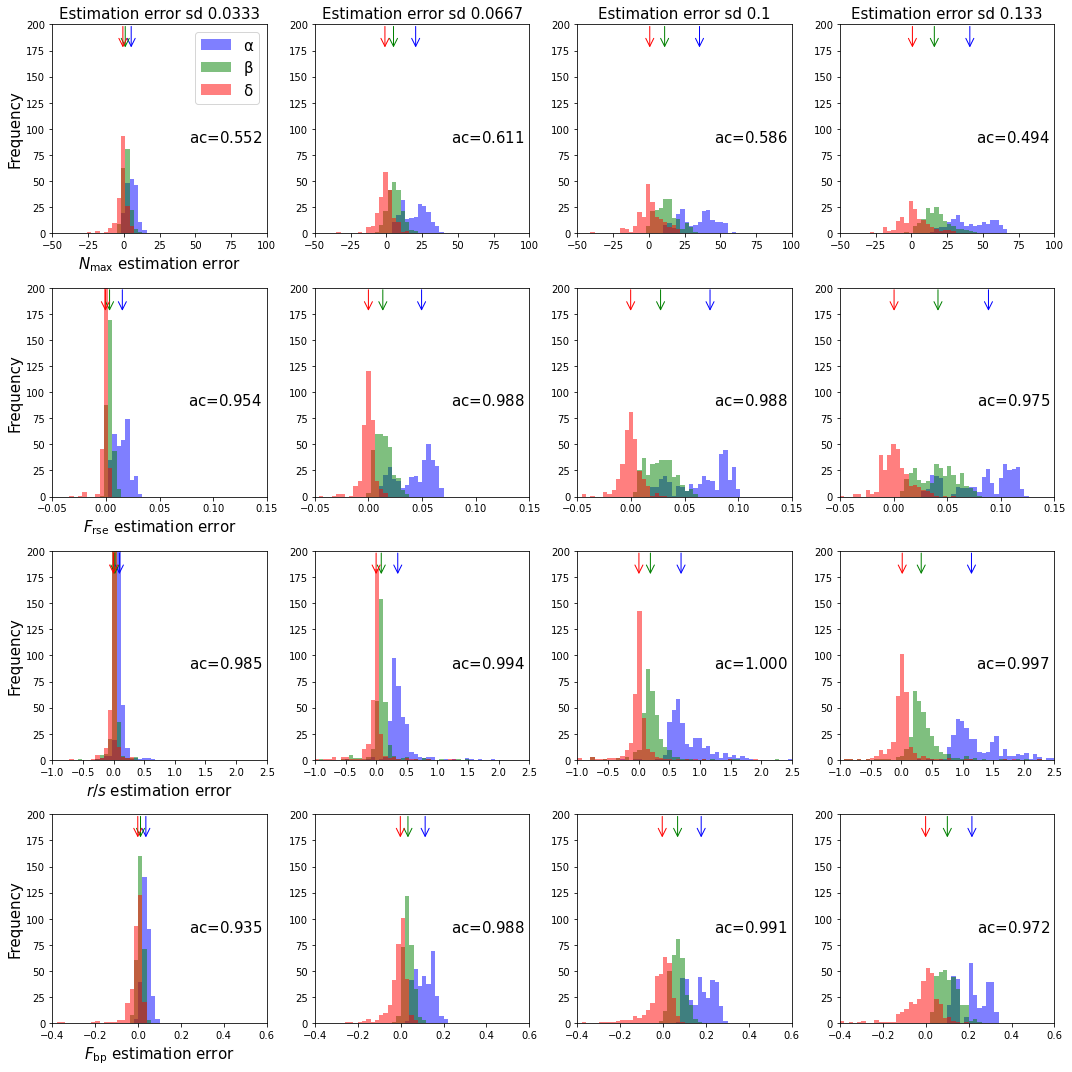

In [17]:
# N_site: number of variable site of landscape; parameter: parameter for data stratification 
# N_site: 5, 10, 15; parameter: 'model', 'replication', 'ruggedness', 'measurement_std'
N_site=10
parameter='measurement_std'

cv_cutoff = 0.5
show_all_A_B = False # If use all available alpha and beta value even though some data might 
                     # fail the extrapolation. Default is False.

fig,axes = plt.subplots(4,4,figsize=[15,15])

#for j,metric in enumerate(['E','1-gamma','1/adptwalk_steps','1-adptwalk_probs']):
for j,metric in enumerate(['N_max','epi','r_s','blocked_ratio']):   
    for i,rep in enumerate([1/30,2/30,3/30,4/30]):
        ax = axes[j,i]
        xlim = para_dict[N_site][metric]['xlim']
        ylim = para_dict[N_site][metric]['ylim']
        idx_all = (all_df['metric'] == metric) & (all_df['N_site'] == N_site) & (all_df[parameter] == rep) \
                    & (all_df['method'] == 'HT3')
        idx = idx_all & (all_df['accept']==True)
        ac = idx.sum()/idx_all.sum()
        for index,color,label in zip(['A','B','C'],['b','g','r'],['α','β','δ']):
            if show_all_A_B and index != 'C':
                hist_df = all_df[index][idx_all]
            else:
                hist_df = all_df[index][idx]
            ax.hist(hist_df, bins = 50,range=(xlim[0],xlim[1]),alpha=0.5, color = color, label=label)

            ax.annotate(s=None,xy=(np.median(hist_df), ylim[1]*22/25), xytext=(np.median(hist_df),ylim[1]),
                         arrowprops={'arrowstyle': '->', 'color': color}, va='center',size=20)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.text(0.98, 0.5, f'$ac$={ac:.3f}', horizontalalignment='right',
                verticalalignment='top', transform=ax.transAxes, fontsize=15)
        if j == 0:
            ax.set_title(title_dict[parameter].format(rep),fontsize=15)
        if i == 0:
            ax.set_ylabel(f'Frequency',fontsize = 15)
            ax.set_xlabel(f'{ruggedness_measure_dict[metric]} estimation error', fontsize = 15)
        if (i == 0) & (j == 0):
            ax.legend(prop={'size': 15})

plt.tight_layout()
plt.show()